# Non-Linear Least Squares Fitting with Python  
For tasks requiring even the slightest amount of sophistication, the use of options like MS Excel becomes unrealistic. At this point, tools like MATLAB, Mathematica, or OriginLab must be employed.  

An increasingly popular option within the sciences is the use of the Python programming language, particularly within the [Jupyter Notebook](http://jupyter.org/) environment, due to the very powerful methods of manipulation and inspection made available through an array of open source packages. In particular, and for our use here, the [Numpy](http://www.numpy.org/) (matrix manipulation), [Scipy](https://www.scipy.org/) (scientific/engineering algorithms), and [Matplolib](https://matplotlib.org/) (advanced plotting) packages offer a robust suite of analysis tools.  

Non-linear least squares fitting in Python can easily be achieved with either of two options: 
+ the [curve_fit()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function from scipy.optimize
+ the [LMFIT](https://lmfit.github.io/lmfit-py/) package, which is a powerful extension of scipy.optimize 

Examples using both are demonstrated below.

In [1]:
# package imports 
from math import *
import numpy as np
from scipy.optimize import curve_fit
from lmfit import Model

%matplotlib inline
import matplotlib.pyplot as plt

The data to be considered will be a simple Gaussian distribution of amplitude, $A$, centered at $x_c$, and standard distribution, $\sigma$:  
### $$ f(x) = \frac{A}{\sqrt{2\pi\sigma^2}} e^{-\big[\frac{(x-x_c)^2}{2\sigma^2}\big]} $$

In [2]:
# define some function to play with
def gaussian(x, amp, xc, sigma):
    return amp*np.exp( -(x-xc)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [3]:
# set initial parameters for fit function
x = np.arange(256)
amp = 1
xc = np.median(x)
sigma = x[-1]/10
noise_factor = 0.05

# make both clean and noisy data
data = gaussian(x, amp, xc, sigma)
noise = data + noise_factor*data.max()*np.random.normal(size=data.shape)

## Method 1: using the [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) package  
The scipy package is easy to use and performs very well, but only returns limited information. Most of the time, though, it's exactly what you want: the fit values and covariance matrix. The diagonal elements of the covariance matrix equal the variance of each fit parameter, which can be used to calculate the fit parameter uncertainties, $\sigma_{ii}$.

### \begin{equation*}
   Cov = \mathbf{\sigma}^2_{i,j} = 
    \begin{pmatrix} 
        \sigma^2_{1} & \sigma_{1}\sigma_{2} & \sigma_{1}\sigma_{3} \\ 
        \sigma_{2}\sigma_{1} & \sigma^2_{2} & \sigma_{2}\sigma_{3} \\ 
        \sigma_{3}\sigma_{1} & \sigma_{3}\sigma_{2} & \sigma^2_{3} 
    \end{pmatrix}
\end{equation*}

Unfortunately, any goodness of fit ($R^2$, $\chi ^2$, etc.) is not returned, but it can easily be calculated:  

### $$R^2 = 1 - \frac{\text{(variance of residual)}}{\text{(total variance)}}$$

In [4]:
# define some initial guess values for the fit routine
guess_vals = [amp*2, xc*0.8, sigma/1.5]

# perform the fit and calculate fit parameter errors from covariance matrix
fit_params, cov_mat = curve_fit(gaussian, x, noise, p0=guess_vals)
fit_errors = np.sqrt(np.diag(cov_mat))

# manually calculate R-squared goodness of fit
fit_residual = noise - gaussian(x, *fit_params)
fit_Rsquared = 1 - np.var(fit_residual)/np.var(noise)

print('Fit R-squared:', fit_Rsquared, '\n')
print('Fit Amplitude:', fit_params[0], '\u00b1', fit_errors[0])
print('Fit Center:   ', fit_params[1], '\u00b1', fit_errors[1])
print('Fit Sigma:    ', fit_params[2], '\u00b1', fit_errors[2])

Fit R-squared: 0.981157645998 

Fit Amplitude: 0.99918323783 ± 0.00871375500935
Fit Center:    127.442685585 ± 0.252050150905
Fit Sigma:     25.0297906895 ± 0.252050155051


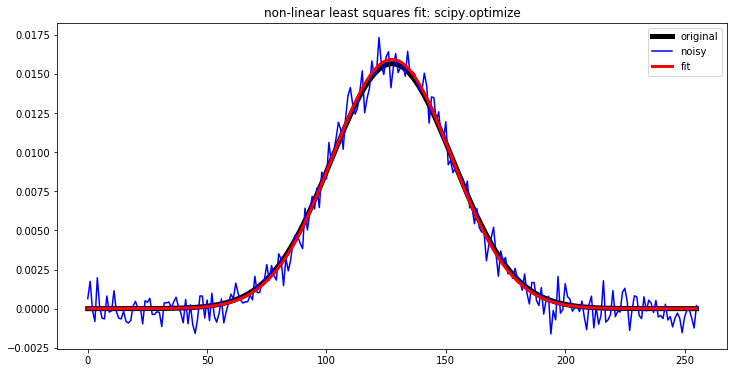

In [5]:
# plotting shizzle 
plt.figure(figsize=(12,6))

plt.plot(x, data, linewidth=5, color='k', label='original')
plt.plot(x, noise, color='b', label='noisy')
plt.plot(x, gaussian(x, *fit_params), linewidth=3, color='r', label='fit')

plt.title('non-linear least squares fit: scipy.optimize')
plt.legend()
plt.show()

## Method 2: using the [LMFIT](https://lmfit.github.io/lmfit-py/model.html) package  

Under the hood, the LMFIT package actually uses scipy.optimize, but adds more advanced functionality for fit options and gives immediate access to fit perfomance and data statistics (see below). Although $\chi^2$ and the $\text{reduced-}\chi^2$ are automatically calculated, $R^2$ is not. Again, it's a trivial matter to calculate it. 

In [6]:
# tell LMFIT what fn you want to fit, then fit, starting iteration with guess values
lmfit_model = Model(gaussian)
lmfit_result = lmfit_model.fit(noise, x=x, 
                               amp=guess_vals[0], 
                               xc=guess_vals[1], 
                               sigma=guess_vals[2])

# again, calculate R-squared
lmfit_Rsquared = 1 - lmfit_result.residual.var()/np.var(noise)

print('Fit R-squared:', lmfit_Rsquared, '\n')
print(lmfit_result.fit_report())

Fit R-squared: 0.981157652083 

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 256
    # variables        = 3
    chi-square         = 1.4434e-04
    reduced chi-square = 5.7050e-07
    Akaike info crit   = -3677.46564
    Bayesian info crit = -3666.83011
[[Variables]]
    amp:    0.99918363 +/- 0.00871359 (0.87%) (init = 2)
    xc:     127.442680 +/- 0.25204182 (0.20%) (init = 102)
    sigma:  25.0298104 +/- 0.25204182 (1.01%) (init = 17)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sigma) =  0.577



In [7]:
# another view of fit parameters
lmfit_result.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp      0.9992     -inf      inf 0.008714     True     None     None
sigma     25.03     -inf      inf    0.252     True     None     None
xc        127.4     -inf      inf    0.252     True     None     None


You might notice here that the parameters can have several conditions placed on them in order to constrain the fit routine, such as: min and max bounds, ability to fix a value, or forcing a parameter to adhere to an analytic expression. Use of these is covered in the LMFIT documentation.

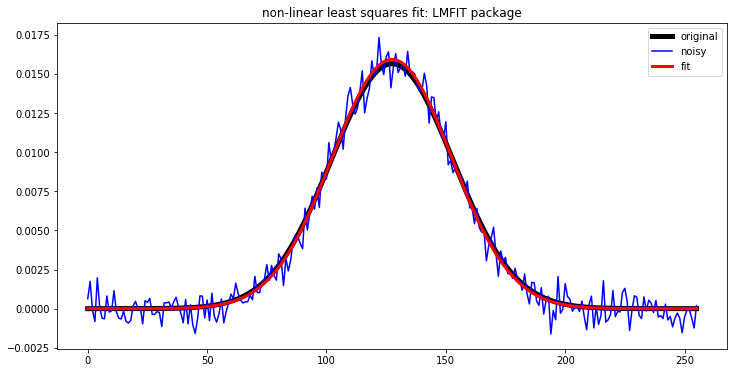

In [8]:
# plotting shizzle 
plt.figure(figsize=(12,6))

plt.plot(x, data, linewidth=5, color='k', label='original')
plt.plot(x, noise, color='b', label='noisy')
plt.plot(x, lmfit_result.best_fit, linewidth=3, color='r', label='fit')

plt.title('non-linear least squares fit: LMFIT package')
plt.legend()
plt.show()

In [9]:
# report best fit parameters with 1*sigma, 2*sigma, and 3*sigma confidence interrvals
print(lmfit_result.ci_report())

          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 amp  :  -0.02620  -0.01739  -0.00869   0.99918  +0.00871  +0.01751  +0.02641
 xc   :  -0.76429  -0.50694  -0.25165 127.44268  +0.25167  +0.50703  +0.76448
 sigma:  -0.74434  -0.49613  -0.24870  25.02981  +0.25106  +0.50647  +0.76698


In [10]:
# show goodness of fits, X^2 and the reduced-X^2
print('Fit X^2:        ', lmfit_result.chisqr)
print('Fit reduced-X^2:', lmfit_result.redchi)

Fit X^2:         0.000144336928221
Fit reduced-X^2: 5.70501692575e-07


In [11]:
# access info on data set and fit performance
print('Number of Data Points:', lmfit_result.ndata)
print('Number of Fit Iterations:', lmfit_result.nfev)
print('Number of freely independent variables:', lmfit_result.nvarys)
print('Did the fit converge?:', lmfit_result.success)

Number of Data Points: 256
Number of Fit Iterations: 25
Number of freely independent variables: 3
Did the fit converge?: True


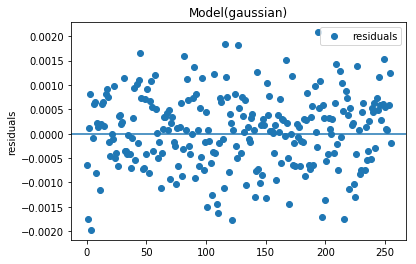

In [12]:
# quickly check the fit residuals (input_data - fit_data)
lmfit_result.plot_residuals();

# Fitting in 2D  
Now, let's look at a more challenging example - least squares fitting over multiple independent dimentions. Why is this challenging? The curve fitting algorithm we're using here only accepts 1D arrays and expects the fitting function to only return a 1D array. But this won't stop us.. We'll just pass a 1D array of *N*D array elements (here, *N* = 2) and use this to build our *N*D fitting function, flattening the output back down to 1D for the function return.  

This time, the data to be considered will be a 2D Gaussian (normal) distribution, without any assumption that variance in the $x$ and $y$ directions are equal ($\sigma_x \neq \sigma_y$):  
### $$ f(x, y) = \frac{A}{2\pi\sigma_x\sigma_y} e^{-\big[\frac{(x-x_c)^2}{2\sigma_x^2} + \frac{(y-y_c)^2}{2\sigma_y^2}\big]} $$

In [13]:
def gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y)
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

## Method 1: using the scipy.optimize package

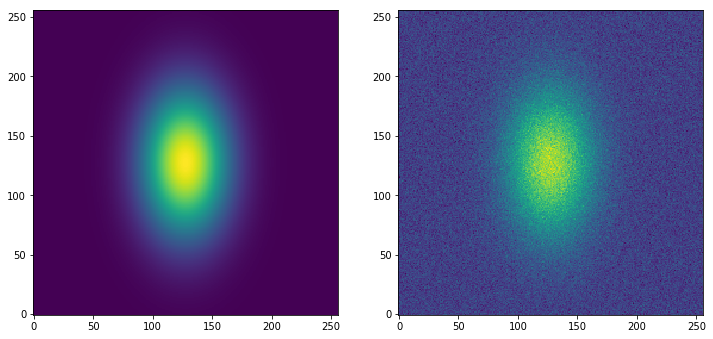

In [14]:
# create the 1D list (xy_mesh) of 2D arrays of (x,y) coords
x = np.arange(256)
y = np.arange(256)
xy_mesh = np.meshgrid(x,y)

# set initial parameters to build mock data
amp = 1
xc, yc = np.median(x), np.median(y)
sigma_x, sigma_y = x[-1]/10, y[-1]/6

noise_factor = 0.07

# make both clean and noisy data, reshaping the Gaussian to proper 2D dimensions
data = gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y).reshape(np.outer(x, y).shape)
noise = data + noise_factor*data.max()*np.random.normal(size=data.shape)

# plot the function and with noise added
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data, origin='bottom')
plt.subplot(1,2,2)
plt.imshow(noise, origin='bottom')
plt.show()

In [15]:
# define some initial guess values for the fit routine
guess_vals = [amp*2, xc*0.8, yc*0.8, sigma_x/1.5, sigma_y/1.5]

# perform the fit, making sure to flatten the noisy data for the fit routine 
fit_params, cov_mat = curve_fit(gaussian_2d, xy_mesh, np.ravel(noise), p0=guess_vals)

# calculate fit parameter errors from covariance matrix
fit_errors = np.sqrt(np.diag(cov_mat))

# manually calculate R-squared goodness of fit
fit_residual = noise - gaussian_2d(xy_mesh, *fit_params).reshape(np.outer(x,y).shape)
fit_Rsquared = 1 - np.var(fit_residual)/np.var(noise)

print('Fit R-squared:', fit_Rsquared, '\n')
print('Fit Amplitude:', fit_params[0], '\u00b1', fit_errors[0])
print('Fit X-Center: ', fit_params[1], '\u00b1', fit_errors[1])
print('Fit Y-Center: ', fit_params[2], '\u00b1', fit_errors[2])
print('Fit X-Sigma:  ', fit_params[3], '\u00b1', fit_errors[3])
print('Fit Y-Sigma:  ', fit_params[4], '\u00b1', fit_errors[4])

Fit R-squared: 0.894077966338 

Fit Amplitude: 1.00232230557 ± 0.00169633351775
Fit X-Center:  127.453386566 ± 0.0431748822038
Fit Y-Center:  127.438987613 ± 0.0722239353075
Fit X-Sigma:   25.5265057847 ± 0.043174882647
Fit Y-Sigma:   42.6923096872 ± 0.0723536665178


In [16]:
# check against actual parameter values
amp, xc, yc, sigma_x, sigma_y

(1, 127.5, 127.5, 25.5, 42.5)

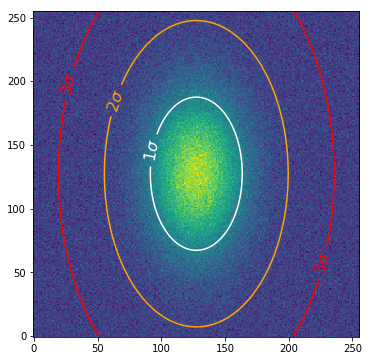

In [17]:
# set contour levels out to 3 sigma
sigma_x_pts = xc + [sigma_x, 2*sigma_x, 3*sigma_x]
sigma_y_pts = yc + [sigma_y, 2*sigma_y, 3*sigma_y]
sigma_xy_mesh = np.meshgrid(sigma_x_pts, sigma_y_pts)

contour_levels = gaussian_2d(sigma_xy_mesh, amp, xc, yc, 
                             sigma_x, sigma_y).reshape(sigma_xy_mesh[0].shape)
contour_levels = list(np.diag(contour_levels)[::-1])

# make labels for each contour
labels = {}
label_txt = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$']
for level, label in zip(contour_levels, label_txt):
    labels[level] = label

# plot the function with noise added
plt.figure(figsize=(6,6))
plt.imshow(noise, origin='bottom')
CS = plt.contour(data, levels=contour_levels, colors=['red', 'orange', 'white'])
plt.clabel(CS, fontsize=16, inline=1, fmt=labels)
plt.show()

## Method 2: using the LMFIT package

In [18]:
# tell LMFIT what fn you want to fit, then fit, starting iteration with guess values
# guess_vals = np.array([amp, xc, yc, sigma_x, sigma_y])*(1+0.2)

lmfit_model = Model(gaussian_2d)
lmfit_result = lmfit_model.fit(np.ravel(noise), 
                               xy_mesh=xy_mesh, 
                               amp=guess_vals[0], 
                               xc=guess_vals[1], 
                               yc=guess_vals[2], 
                               sigma_x=guess_vals[3], 
                               sigma_y=guess_vals[4])

# again, calculate R-squared
lmfit_Rsquared = 1 - lmfit_result.residual.var()/np.var(noise)

print('Fit R-squared:', lmfit_Rsquared, '\n')
print(lmfit_result.fit_report())

Fit R-squared: 0.894077966338 

[[Model]]
    Model(gaussian_2d)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 65536
    # variables        = 5
    chi-square         = 6.8762e-06
    reduced chi-square = 1.0493e-10
    Akaike info crit   = -1505862.77
    Bayesian info crit = -1505817.32
[[Variables]]
    amp:      1.00232231 +/- 0.00169633 (0.17%) (init = 2)
    xc:       127.453387 +/- 0.04317488 (0.03%) (init = 102)
    yc:       127.438988 +/- 0.07222394 (0.06%) (init = 102)
    sigma_x:  25.5265058 +/- 0.04317488 (0.17%) (init = 17)
    sigma_y:  42.6923097 +/- 0.07235367 (0.17%) (init = 28.33333)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sigma_y) =  0.501
    C(amp, sigma_x) =  0.500



In [19]:
lmfit_result.params.pretty_print()

Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp         1.002     -inf      inf 0.001696     True     None     None
sigma_x     25.53     -inf      inf  0.04317     True     None     None
sigma_y     42.69     -inf      inf  0.07235     True     None     None
xc          127.5     -inf      inf  0.04317     True     None     None
yc          127.4     -inf      inf  0.07222     True     None     None


In [20]:
# check against actual parameter values
amp, xc, yc, sigma_x, sigma_y

(1, 127.5, 127.5, 25.5, 42.5)